In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from brian2 import start_scope, prefs, run
from brian2 import PoissonGroup, NeuronGroup, Synapses, StateMonitor, SpikeMonitor, TimedArray
from brian2 import ms, mV, Hz

# Import libraries from outside folder
import sys
sys.path.append('../lib/')

import traces_lib, opencv_lib

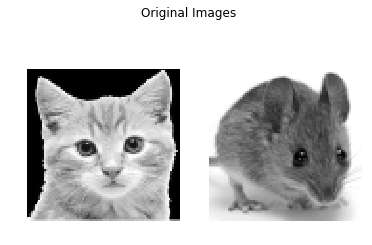

In [9]:
# Load raw images
# img1 = (mpimg.imread('img/cat4.png')[:,:,0] > 0.5).astype(int)
# img2 = (mpimg.imread('img/mouse4.png')[:,:,0] > 0.5).astype(int)
img1 = mpimg.imread('../img/cat4.png')
img2 = mpimg.imread('../img/mouse4.png')

# Plot raw images
fig, axis = plt.subplots(ncols=2)
axis[0].imshow(img1, cmap='gray')
axis[1].imshow(img2, cmap='gray')
axis[0].set_axis_off()
axis[1].set_axis_off()
plt.suptitle('Original Images')
plt.show()

## Solution 1 (Not so good solution)

Plasticity of the spiking threshold: Increase threshold by fixed amout at every spike, and use homeostatic decay to restore it to resting threshold. This way, neurons that fire more should have higher threshold, which would in turn decrease their firing rate.

<table><tr><td>
    $
    \begin{eqnarray}
      \dot{V}(t) &=& \frac{V_0 - V}{\tau_V} + \dot{V}_{\mathrm{inp}}(t) - T(t)S(t) \\
      \dot{T}(t) &=& \frac{T_0 - T}{\tau_T} + \Delta T_{\mathrm{spike}} S(t)
    \end{eqnarray}
    $
</td></tr></table>

where the spike function is given by
<table><tr><td>
    $S(t) = \sum_i \delta(t - t_i)$
</td></tr></table>


**What is the stable fixed point of threshold given a fixed input?**

Applying the time average defined as $\langle f(t) \rangle_{t} = \lim_{T \rightarrow \infty}\frac{1}{T} \int_0^T f(t)dt$ to the membrane potential ODE, we obtain that the steady state spike rate is approximately
<table><tr><td>
    $R \approx  \frac{\dot{V}_{\mathrm{inp}}}{T}$
</td></tr></table>
Applying the time-average to the threshold ODE and plugging in the rate, we obtain the quadratic equation for the steady state threshold
<table><tr><td>
    $\Delta T_{\mathrm{spike}} \frac{T_0 - T}{\tau_T} + \frac{\dot{V}_{inp}}{T} = 0$
</td></tr></table>
Solving fixed point equation for $T$
<table><tr><td>
$T_{fix} = T_0 \bigl(0.5 + \sqrt{0.5^2 + \zeta \dot{V}_{inp}} \bigr)$ where $\zeta = \frac{\Delta T \tau_T}{T_0^2}$
</td></tr></table>
A possible application of such system is to be a predictor - fire more than average spikes only if the input is different from the one observed before, averaged over a certain memory window of time length $\approx \tau_T$. Fully achieving this is impossible, since the terminal average spiking rate $\frac{\dot{V}_{inp}}{T}$ scales approximately as $\sqrt{\dot{V}_{inp}}$. So the neurons that receive more input will fire more even after the threshold has adapted. For larger $\zeta$ parameter values, the terminal ratio between spikes fired for small and for large inputs will be smaller, but also the total number of spikes fired will be smaller.

In [10]:
%%time
start_scope()
prefs.codegen.target = "numpy"

#######################################
# Neuron constants
#######################################

N_NEURON = img1.shape[0] * img1.shape[1]
print('Number of neurons is', N_NEURON)

RUN_TIME = 1000*ms

LIF_V_TAU = 10*ms
LIF_V_0 = 0.0*mV

LIF_T_TAU = 400*ms
LIF_T_0 = 1.0*mV
LIF_T_AVG = 50.0*mV
LIF_DT_PER_SPIKE = 2*LIF_T_AVG * (LIF_V_TAU / LIF_T_TAU)
print("Threshold growth per spike is", LIF_DT_PER_SPIKE)


#######################################
# Input constants
#######################################

# Sync input voltage, so that for average threshold the leak would balance out the input
INPUT_FREQ_0 = 10*Hz
INPUT_FREQ_MAX = 100*Hz
INPUT_FREQ_AVG = INPUT_FREQ_0 + INPUT_FREQ_MAX / 2
INPUT_DV_PER_SPIKE = LIF_T_AVG / LIF_V_TAU / INPUT_FREQ_AVG
print("Typical threshold is", LIF_T_AVG, ", voltage increase per spike is", INPUT_DV_PER_SPIKE)


#######################################
# Neuron Equations
#######################################

# Membrane potential V and threshold T both return back to resting values over time
eqs_neu = '''
dv/dt = (LIF_V_0 - v) / LIF_V_TAU : volt
dT/dt = (LIF_T_0 - T) / LIF_T_TAU : volt
'''

# On spike, the threshold is increased
reset = '''
v = LIF_V_0
T += LIF_DT_PER_SPIKE
'''

# Connect Input and LIF one-to-one
G_INP = PoissonGroup(N_NEURON, INPUT_FREQ_0 + INPUT_FREQ_MAX * np.ndarray.flatten(img1))
G_LIF = NeuronGroup(N_NEURON, eqs_neu, threshold='v > T', reset=reset, method='exact')
S = Synapses(G_INP, G_LIF, on_pre='v_post += INPUT_DV_PER_SPIKE')
S.connect(j='i')

# Monitor the value of one neuron somewhere in the middle of the image
M = StateMonitor(G_LIF, 'v', record=3000)
spikemon_inp = SpikeMonitor(G_INP)
spikemon_lif = SpikeMonitor(G_LIF)

run(RUN_TIME)

Number of neurons is 6400
Threshold growth per spike is 2.5 mV
Typical threshold is 50. mV , voltage increase per spike is 83.33333333 mV


/home/aleksejs/.local/lib/python3.6/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  return np.issubdtype(np.bool, self.dtype)
/home/aleksejs/.local/lib/python3.6/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(np.bool, self.dtype)


CPU times: user 2.87 s, sys: 24 ms, total: 2.89 s
Wall time: 2.91 s


Started writing video rez/test1_lif_sol1_inp.avi of 1000 frames using time step 0.001
Started writing video rez/test1_lif_sol1_lif.avi of 1000 frames using time step 0.001
Min threshold after training is 0.001869799467132131
Max threshold after training is 0.0922836300306135
Average threshold after training is 0.055952939688158704


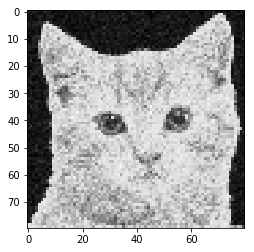

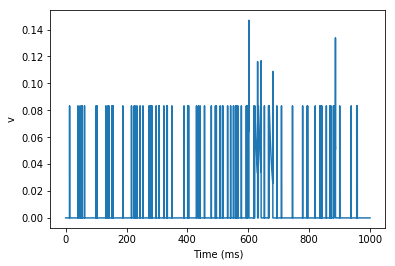

In [11]:
#######################################
# Write videos
#######################################

traces_lib.spikes2rateVideo(
    'rez/test1_lif_sol1_inp.avi',
    img1.shape,
    np.array(spikemon_inp.i),
    np.array(spikemon_inp.t),
    0,
    float(RUN_TIME),
    1000,
    0.1,
    maxRate=100)

traces_lib.spikes2rateVideo(
    'rez/test1_lif_sol1_lif.avi',
    img1.shape,
    np.array(spikemon_lif.i),
    np.array(spikemon_lif.t),
    0,
    float(RUN_TIME),
    1000,
    0.05,
    maxRate=100)

#Plot resulting threshold values
print("Min threshold after training is", np.min(np.array(G_LIF.T)))
print("Max threshold after training is", np.max(np.array(G_LIF.T)))
print("Average threshold after training is", np.average(np.array(G_LIF.T)))
plt.figure()
plt.imshow(np.array(G_LIF.T).reshape(img1.shape), cmap='gray')
plt.show()

plt.figure()
plt.plot(M.t/ms, M.v[0])
plt.xlabel('Time (ms)')
plt.ylabel('v');

# Solution 2 (Good Solution)

Introduce a 3rd variable, that integrates spike rate over time. Adapt threshold to increase when rate is more than average, and decrease when rate is less than average.

<table><tr><td>
    $
    \begin{eqnarray}
      \dot{V}(t) &=& \frac{V_0 - V}{\tau_V} + I(t) - V_{\max}S(t) \\
      \dot{R}(t) &=& \frac{S(t) - R}{\tau_R} \\
      \dot{T}(t) &=& \biggl(\frac{R}{R_{avg}} - 1\biggr) \frac{T_{avg}}{\tau_T}
    \end{eqnarray}
    $
</td></tr></table>

This design attracts the rate to $R_{avg}$ by changing threshold. This allows the neurons to adapt to constant input, having their long-term spike-rates unaffected. One remaining problem is that the change of threshold is independent of the threshold magnitude, allowing the threshold to exceed natural boundaries. It is possible to simply clip the threshold back to the allowed range, but it is not a biologically feasible solution. Assuming that the threshold is biologically bounded $[T_{\min}, T_{\max}]$, a plausible guess is that the threshold exponentially saturates at these values. For example, if the threshold is nearby $T_{\min}$, it would decrease very slowly, but grow rather fast and vice-versa. A sharp equation based on Heaviside step function $\Theta(x)$ can be given by

<table><tr><td>
    $ \dot{T}(t) = \frac{\epsilon_R}{\tau_T} \bigl( \Theta(\epsilon_R)(T-T_{\max}) - \Theta(-\epsilon_R)(T-T_{\min}) \bigr) $
</td></tr></table>    
where
<table><tr><td>
    $\epsilon_R = \biggl(\frac{R}{R_{avg}} - 1\biggr)$
</td></tr></table>

For even further biological plausibility, the step function can be replaced by a sharp logistic function.

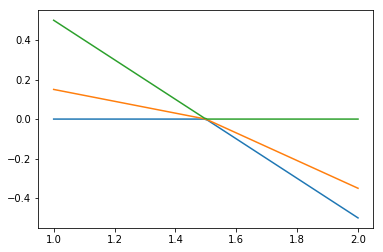

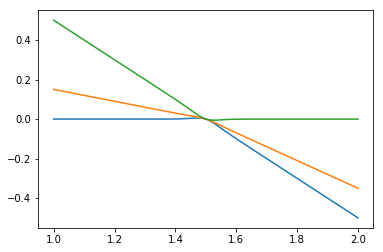

In [12]:
def step(x):
    return np.heaviside(x, 0)

def sig(x):
    return 1 / (1 + np.exp(-50*x))

def dotTsharp(t, r):
    return (r-1.5)*(step(r-1.5)*(t-2) - step(1.5-r)*(t-1))

def dotTsig(t, r):
    return (r-1.5)*(sig(r-1.5)*(t-2) - sig(1.5-r)*(t-1))

r = np.linspace(1, 2, 100)
plt.figure()
plt.plot(r, dotTsharp(1, r))
plt.plot(r, dotTsharp(1.3, r))
plt.plot(r, dotTsharp(2, r))
plt.show()

plt.figure()
plt.plot(r, dotTsig(1, r))
plt.plot(r, dotTsig(1.3, r))
plt.plot(r, dotTsig(2, r))
plt.show()

In [17]:
%%time
start_scope()
prefs.codegen.target = "numpy"

#######################################
# Neuron constants
#######################################

N_NEURON = img1.shape[0] * img1.shape[1]
print('Number of neurons is', N_NEURON)

RUN_TIME_1_SIM = 1000*ms
RUN_TIME_TOT = 3 * RUN_TIME_1_SIM
OUTPUT_SAMPLING_TIMESCALE = 1*ms

# Membrane potential
LIF_V_TAU = 10*ms   # Decay timescale
LIF_V_0 = 0.0*mV    # Resting value

# Spike rate trace
LIF_R_TAU = 100*ms   # Decay timescale
LIF_R_0 = 0.0*Hz     # Resting value
LIF_R_AVG = 10.0*Hz  # Resting value

# Spiking threshold potential
LIF_T_TAU = 2000*ms         # Decay timescale
#LIF_T_ALPHA = 1 * mV / Hz  # Effect size of rate change on threshold change
# LIF_T_ALPHA = 0.01          # Effect size of rate change on threshold change
LIF_T_MIN = 10*mV           # Initial expected threshold
LIF_T_MAX = 400*mV          # Initial expected threshold
LIF_T_AVG = 50*mV           # Initial expected threshold


#######################################
# Input constants
#######################################

# Sync input voltage, so that for average threshold the leak would balance out the input
INPUT_FREQ_0 = 10*Hz
INPUT_FREQ_MAX = 100*Hz
INPUT_FREQ_AVG = INPUT_FREQ_0 + INPUT_FREQ_MAX / 2
INPUT_DV_PER_SPIKE = LIF_T_AVG / LIF_V_TAU / INPUT_FREQ_AVG
print("Typical threshold is", LIF_T_AVG, ", voltage increase per spike is", INPUT_DV_PER_SPIKE)


#######################################
# Neuron Equations
#######################################

# Membrane potential V leaks over time and is reinforced by input
# Neural spike rate R counts spikes of this neuron within a decaying time window
eqs_neu = '''
dv/dt = (LIF_V_0 - v) / LIF_V_TAU : volt
dR/dt = (LIF_R_0 - R) / LIF_R_TAU : Hz
dT/dt = (R/LIF_R_AVG - 1) / LIF_T_TAU * ((LIF_T_MAX - T)/ (1 + exp(-20*(R/LIF_R_AVG - 1))) + (T - LIF_T_MIN) / (1 + exp(20*(R/LIF_R_AVG - 1)))) : volt
'''
# dT/dt = (R/LIF_R_AVG - 1) / LIF_T_TAU * ((LIF_T_MAX - T)/ (1 + heaviside(R/LIF_R_AVG - 1)) + (T - LIF_T_MIN) / (1 + heaviside(R/LIF_R_AVG - 1))) : volt
# dT/dt = (R/LIF_R_AVG - 1) / LIF_T_TAU * ((LIF_T_MAX - T)/ (1 + exp(-20*(R/LIF_R_AVG - 1))) + (T - LIF_T_MIN) / (1 + exp(20*(R/LIF_R_AVG - 1)))) : volt
# dT/dt = (R/LIF_R_AVG - 1) * (T - LIF_T_MIN) / LIF_T_TAU : volt
# dT/dt = (R/LIF_R_AVG - 1) * LIF_T_AVG / LIF_T_TAU : volt


# On spike, the threshold is increased
reset = '''
v = LIF_V_0
R += 1 / LIF_R_TAU
'''

#######################################
# Generate input
#######################################

rates1 = INPUT_FREQ_0 + INPUT_FREQ_MAX * np.ndarray.flatten(img1)
rates2 = INPUT_FREQ_0 * np.ones(N_NEURON)
rates3 = INPUT_FREQ_0 + INPUT_FREQ_MAX * np.ndarray.flatten(img2)
rates_all = np.vstack((rates1, rates2, rates3)) * Hz

# NOTE: The poisson rate is changed with time step dt, resulting in new input
rateTimedArray = TimedArray(rates_all, dt = RUN_TIME_1_SIM)

#######################################
# Connect neurons
#######################################

# Connect Input and LIF one-to-one
#G_INP = PoissonGroup(N_NEURON, INPUT_FREQ_0 + INPUT_FREQ_MAX * np.ndarray.flatten(img1))
#G_INP = SpikeGeneratorGroup(N_NEURON, spInd123, spTimes123)
G_INP = PoissonGroup(N_NEURON, rates="rateTimedArray(t, i)")
G_LIF = NeuronGroup(N_NEURON, eqs_neu, threshold='v > T', reset=reset)#, method='exact')
S = Synapses(G_INP, G_LIF, on_pre='v_post += INPUT_DV_PER_SPIKE')
S.connect(j='i')

# Initialize variables, that are not 0 at the start
G_LIF.R = LIF_R_AVG  # Set initial rate to expected rate
G_LIF.T = LIF_T_AVG  # Set initial threshold to expected threshold

# Monitor the value of one neuron somewhere in the middle of the image
M = StateMonitor(G_LIF, 'T', record=True, dt=OUTPUT_SAMPLING_TIMESCALE)
spikemon_inp = SpikeMonitor(G_INP)
spikemon_lif = SpikeMonitor(G_LIF)

#######################################
# Run simulation
#######################################

run(RUN_TIME_TOT)

Number of neurons is 6400
Typical threshold is 50. mV , voltage increase per spike is 83.33333333 mV


/home/aleksejs/.local/lib/python3.6/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  return np.issubdtype(np.bool, self.dtype)


SyntaxError: Unknown syntax: Call (<string>)

Started writing video rez/test1_lif_sol2_inp.avi of 3000 frames using time step 0.001
Started writing video rez/test1_lif_sol2_lif.avi of 3000 frames using time step 0.001
Min threshold after training is 0.081995259381522
Max threshold after training is 0.2539135240202334
Average threshold after training is 0.16909835423952424


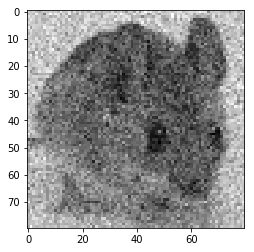

In [15]:
#######################################
# Write videos
#######################################

TAU_SMOOTH = 0.05
N_DISCR_STEPS = int(RUN_TIME_TOT / OUTPUT_SAMPLING_TIMESCALE)

# Input spikes
traces_lib.spikes2rateVideo(
    'rez/test1_lif_sol2_inp.avi',
    img1.shape,
    np.array(spikemon_inp.i),
    np.array(spikemon_inp.t),
    0,
    float(RUN_TIME_TOT),
    N_DISCR_STEPS,
    TAU_SMOOTH)

# Spikes
traces_lib.spikes2rateVideo(
    'rez/test1_lif_sol2_lif.avi',
    img1.shape,
    np.array(spikemon_lif.i),
    np.array(spikemon_lif.t),
    0,
    float(RUN_TIME_TOT),
    N_DISCR_STEPS,
    TAU_SMOOTH)

# Threshold trace
traceT = (np.array(M.T) * 255 / LIF_T_MAX).astype(int)
with opencv_lib.cvWriter('rez/test1_lif_sol2_T.avi', img1.shape, codec='MJPG') as vid:
    for i in range(traceT.shape[1]):
        vid.write(traceT[:,i].reshape(img1.shape))

#Plot resulting threshold values
print("Min threshold after training is", np.min(np.array(G_LIF.T)))
print("Max threshold after training is", np.max(np.array(G_LIF.T)))
print("Average threshold after training is", np.average(np.array(G_LIF.T)))
plt.figure()
plt.imshow(np.array(G_LIF.T).reshape(img1.shape), cmap='gray')
plt.show()